### This notebook was mainly created by Dr. Andreu Casas for several workshops and summer/fall schools. The code has been adapted but all credit goes to him.


## Install the packages/modules that we'll be using. Set up GPU.

These google-colab notebooks allow us to run code in virtual machines located
elsewhere. Every time we start a session, the virtual machine is "empty", so
non-native python modules need to be installed. Let's install the ones we'll
need in this particular notebook. We'll do so using `pip` and the `!` marker
that allows us to run `bash` code in the same notebook.


In [1]:
# - before getting started, set up GPU.
import tensorflow as tf

# - get the GPU device name.
device_name = tf.test.gpu_device_name()

# - the device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
# - a function we'll need to process images before using them as input of CNNs
def data_transform(train = True, mean = [0.485, 0.456, 0.406],
                  sd = [0.229, 0.224, 0.225],
                  scale = 256, random_crop = 224):
    """
    Description: This function creates an object to transform train and
        test (or only testing) images.
    Parameters:
        `train`: type <bool> indicating if the object will need to be used
                    to transform training and testing images (=True) or
                    only testing.
        `mean`: type <list> of 3 floats indicating the mean value of the 3 RGB
                    image inputs.
        `sd`: type <list> of 3 floats indicating the standard deviation of
                    the 3 RGB mean inputs.
        `scale`: type <int> indicating the new size to give to the train and
                    test data (e.g. 256x256 pixel images).
        `random_crop`: type <int> indicating the size of the part of the image
                    really used for training-testing (e.g. 224x224)
    Output:
        An object to be used for preprocessing the train and test images
    Example:
        preprocess = data_transform()
    """
    if train:
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(scale),
                transforms.RandomResizedCrop(random_crop),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
            'test': transforms.Compose([
                transforms.Resize(scale),
                transforms.CenterCrop(random_crop),
                transforms.ToTensor(),
                transforms.Normalize(mean, sd)
            ]),
        }
    else:
        data_transforms = transforms.Compose([
            transforms.Resize(scale),
            transforms.CenterCrop(random_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, sd)
        ])
    return(data_transforms)

## 1. Load the modules that we'll be using


In [3]:
import os
from PIL import Image, ImageOps # also for image manipulation
import numpy as np
import cv2 # module for simple computer vision tasks
import json
import time
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# - pytorch for deep learning modeling
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision.datasets as datasets

Download the "Archive.zip" file from the Github and drag it into the runtime storage (click on the folder sign on the left side).

In [5]:
!unzip /content/Archive

Archive:  /content/Archive.zip
  inflating: dog.jpeg                
   creating: protest/
  inflating: protest/.DS_Store       
   creating: protest/test/
   creating: protest/train/
   creating: protest/test/positive/
  inflating: protest/test/.DS_Store  
   creating: protest/test/negative/
   creating: protest/train/positive/
  inflating: protest/train/.DS_Store  
   creating: protest/train/negative/
  inflating: protest/test/positive/42512.jpg  
  inflating: protest/test/positive/42272.jpg  
  inflating: protest/test/positive/45021.jpg  
  inflating: protest/test/positive/51085.jpg  
  inflating: protest/test/positive/5393.jpg  
  inflating: protest/test/positive/50988.jpg  
  inflating: protest/test/positive/37456.jpg  
  inflating: protest/test/positive/53260.jpg  
  inflating: protest/test/positive/42386.jpg  
  inflating: protest/test/positive/44938.jpg  
  inflating: protest/test/positive/44656.jpg  
  inflating: protest/test/positive/42094.jpg  
  inflating: protest/test/posi

In [6]:
data_path = '/content/'

## Loading images


In [7]:
# - use the functionalities of the PIL package to load an example image. Let's
#   use one of the images of the celebrity dataset.
celeb_path = '{}small-celeb-data/train/'.format(data_path)
img_path = '{}elton_john/httpssmediacacheakpinimgcomxfcfcbaeaeddabbjpg.jpg'.format(
    celeb_path
)
# - /!\ here is where the loading takes place
img = Image.open(img_path)

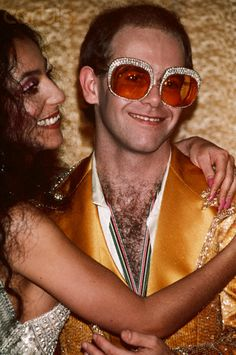

In [8]:
img

## Image representations


### RGB 3-D representation


In [9]:
# - transform the PIL Image object to a numpy array to explore the raw 3-D
#   RGB representation.
img_array = np.array(img)

In [10]:
# - a 3D array containin information about the intensity of Red, Green, and Blue
#   for each pixel in the image.
#   These color intensities range from 0 (meaning there is no e.g. Red), to 255.
img_array.shape # width, height, depth

(355, 236, 3)

array([[[111,  78,  37],
        [115,  82,  41],
        [114,  82,  41],
        ...,
        [154, 128,  93],
        [151, 125,  90],
        [142, 116,  81]],

       [[104,  71,  30],
        [111,  78,  37],
        [112,  80,  39],
        ...,
        [139, 113,  78],
        [136, 110,  75],
        [131, 105,  70]],

       [[101,  68,  25],
        [107,  74,  31],
        [109,  76,  33],
        ...,
        [100,  74,  39],
        [ 95,  69,  34],
        [ 96,  70,  35]],

       ...,

       [[ 68,  70,  57],
        [106, 108,  95],
        [145, 147, 133],
        ...,
        [126,  55,  11],
        [154,  77,  25],
        [172,  91,  35]],

       [[ 34,  37,  26],
        [ 73,  76,  65],
        [ 97,  99,  86],
        ...,
        [121,  50,   4],
        [152,  71,  16],
        [170,  84,  23]],

       [[ 74,  77,  66],
        [111, 114, 103],
        [116, 118, 105],
        ...,
        [111,  40,   0],
        [140,  59,   4],
        [157,  73,  13]]], dtype=uint8)
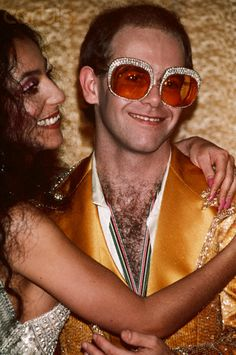

In [11]:
img_array

In [12]:
img_array.min()

0

In [13]:
img_array.max()

255

In [14]:
# - let's get rid of the first color channel (Red)
img_array[:,:,0] = 0

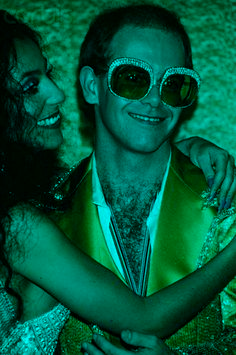

In [15]:
Image.fromarray(img_array)

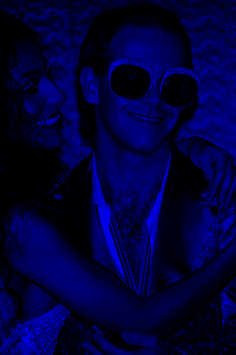

In [16]:
# - let's do the same with the second color channel (Green)
img_array[:,:,1] = 0
Image.fromarray(img_array)

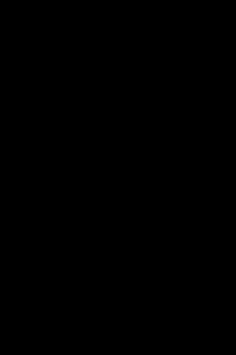

In [17]:
# - and finally get rid of the third color channel (Blue)
img_array[:,:,2] = 0
Image.fromarray(img_array)

### Grayscale 2-D representation


In [18]:
# - use one of the functions in the PIL module to transform the sample image to
#   grayscale
img_gray = ImageOps.grayscale(img)

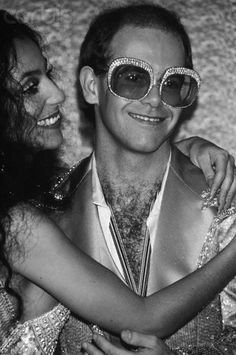

In [19]:
img_gray

In [20]:
# - transform to a numpy array to check how the grayscale representation looks
imggray_array = np.array(img_gray)

In [21]:
# - only 2 dimensions (height, width) -- no depth (so no 3-color channel)
imggray_array.shape

(355, 236)

array([[ 83,  87,  87, ..., 132, 129, 120],
       [ 76,  83,  85, ..., 117, 114, 109],
       [ 73,  79,  81, ...,  78,  73,  74],
       ...,
       [ 68, 106, 145, ...,  71,  94, 109],
       [ 35,  74,  97, ...,  66,  89, 103],
       [ 75, 112, 116, ...,  57,  77,  91]], dtype=uint8)
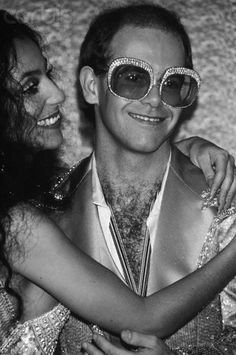

In [22]:
# - the numbers indicate the intensity of black/gray in each pixel. Same range,
#   from 0 (completely black) to 255 (completely white).
imggray_array

In [23]:
imggray_array.min()

2

In [24]:
imggray_array.max()

254

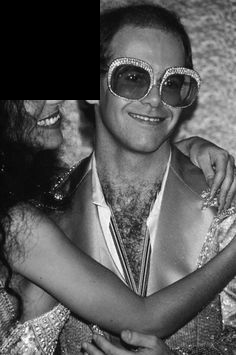

In [25]:
imggray_array[0:100,0:100] = 0
Image.fromarray(imggray_array)

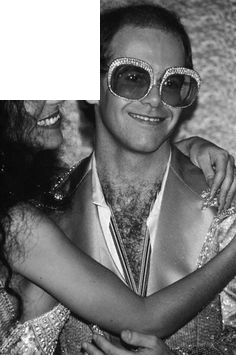

In [26]:
imggray_array[0:100,0:100] = 255
Image.fromarray(imggray_array)

## Image embedding

Sometimes we want to leverage the information learned by rich pre-trained deep
models and express images as embeddings/vectors. We can then use such embeddings
e.g. to compute image similarity.


In [27]:
# - load pre-trained image model: Resnet18.
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


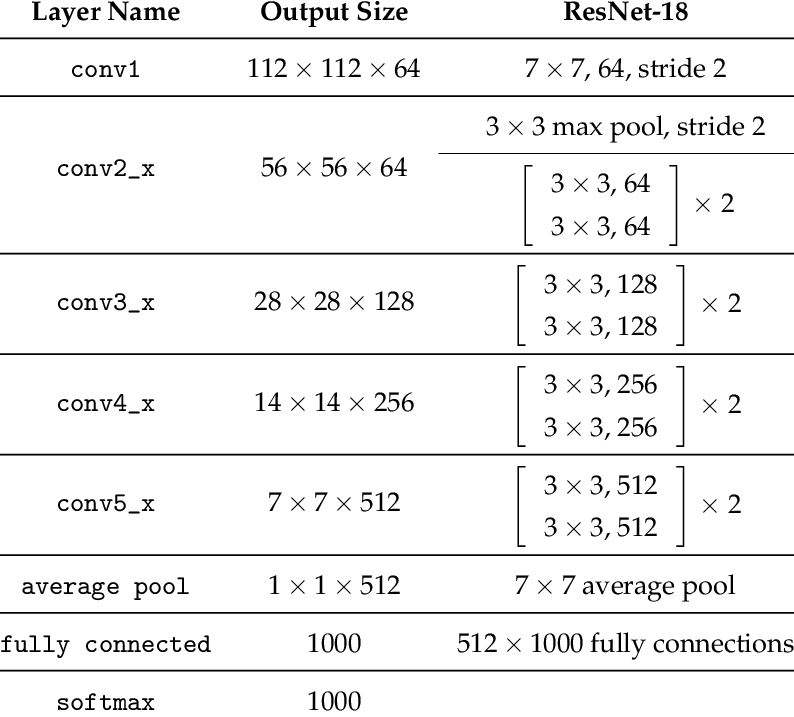


In [28]:
# - we will get rid of the last fully connected layer, which means that we'll
#   generate embeddings of size 512. And we'll make sure we don't run
#   backpropagation.
for param in model.parameters(): #
    param.requires_grad = False
model.eval()

encoder = nn.Sequential(*list(model.children())[:-1]) # drop last layer
resnet_preprocess = data_transform(train = False) # preprocessing info
if torch.cuda.is_available(): # making sure we're using GPUs
    model = model.cuda()

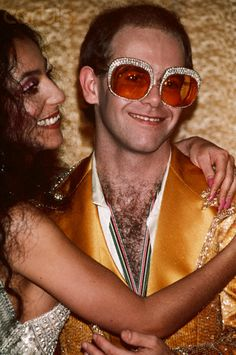

In [29]:
img

In [30]:
# - use the encoder (pre-trained CNN -- Resnet18), to represent the sample image
#   as a dense vector
# ... transform the image (centering the color values)
img_transformed = Variable(resnet_preprocess(img).unsqueeze(0))

In [31]:

img_embedding = encoder(img_transformed.cuda()).cpu().detach().numpy().flatten()


In [32]:
img_embedding

array([7.26116728e-03, 3.99091095e-01, 9.34610784e-01, 8.93190384e-01,
       6.43264279e-02, 5.07065237e-01, 1.45919514e+00, 4.19779658e-01,
       5.70402220e-02, 6.52929664e-01, 4.41477746e-01, 3.09692807e-02,
       3.78920346e-01, 1.03381562e+00, 1.47369593e-01, 1.87598482e-01,
       1.19010711e+00, 1.58331203e+00, 2.38820836e-01, 1.47106218e+00,
       4.23926950e-01, 6.50966406e-01, 1.75591990e-01, 7.24376261e-01,
       1.52686512e+00, 8.57232273e-01, 1.96643591e+00, 1.49553704e+00,
       1.41258493e-01, 7.52044395e-02, 1.08328795e+00, 5.06776392e-01,
       7.69568920e-01, 2.99374270e+00, 1.32562125e+00, 4.36387286e-02,
       5.64955235e-01, 2.35879615e-01, 2.93433487e-01, 5.30508101e-01,
       9.17641163e-01, 1.42532420e+00, 3.84310317e+00, 6.62209630e-01,
       3.79334736e+00, 6.46839499e-01, 9.87194598e-01, 1.35602367e+00,
       6.08735561e-01, 1.82718575e+00, 1.05383016e-01, 4.80766296e-02,
       1.14858272e-02, 4.54576522e-01, 7.75712058e-02, 9.53256309e-01,
      

In [33]:
len(img_embedding)

512

## Basic image processing


### Resizing / Squishing

Often we want to work with images of the same exact size, usually a square
format (e.g. 224 x 224). For example, when feeding images to a pre-trained CNN
model. An option when the original image files are of different size, is to
resize them so they are all of the same size. However, as you will see, we may
end up deforming images too much, complicating many analytical tasks down the
line.


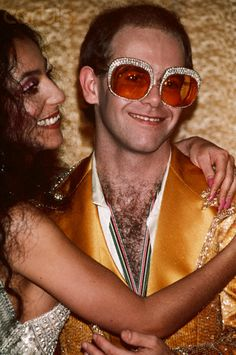

In [34]:
# - let's keep working with this same image example
img

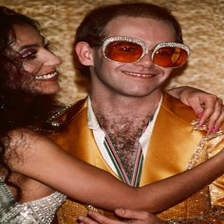

In [35]:
# - PIL Image objects/classes already come with a resize function. Let's try it!
img.resize((224,224))

### 6.2 Cropping

An alternative to avoid deforming the image is to crop part of it. The problem
there however is that we may end up missing parts of the images that are
relevant for our analysis.


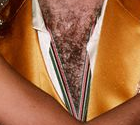

In [36]:
# - the PIL Image class comes with a function to do the cropping. You need to
#   provide a 4-coord box to this function indicating the (left, top, right,
#   bottom) points to use during cropping
img.crop((60, 175, 200, 300))

### Cropping and Resizing

A better alternative is to combine cropping and resizing. First, we make sure we
have a square image (the width and the height is the same) by excluding the
least parts/amounts of the image possible. Then, we transform the square image
to the desired size.


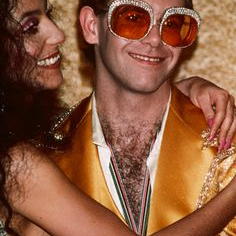

In [37]:
height = img.height
width = img.width
hw_dif = abs(height - width)
hw_halfdif = hw_dif / 2
crop_leftright = width > height
if crop_leftright:
    y0 = 0
    y1 = height
    x0 = 0 + hw_halfdif
    x1 = width - hw_halfdif
else:
    y0 = 0 + hw_halfdif
    y1 = height - hw_halfdif
    x0 = 0
    x1 = width
img.crop((x0, y0, x1, y1))

### Rotation

For data-augmentation and generalizability purposes, we want to rotate images at
random when training a deep learning image model. The tasks explain in this
section 7, including rotation, are handled automatically by any deep learning
library (e.g. `pytorch`). Nevertheless, it's also good to know how to do these
things "manually", to know what's going on in the back (which e.g. helps
debugging) but also in case you need to do it by yourself in the future.


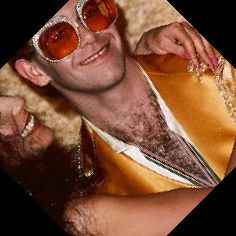

In [38]:
# - the PIL Image class also comes with a rotate function. You only need to
#   specify the angles to be rotated.
img.crop((x0, y0, x1, y1)).rotate(45)

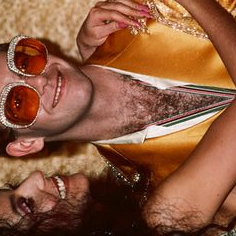

In [39]:
img.crop((x0, y0, x1, y1)).rotate(90)

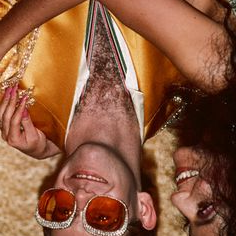

In [40]:
img.crop((x0, y0, x1, y1)).rotate(180)

## Load a pre-trained model and perform zero-shot classfication

`PyTorch` make it very easy to load and use CNN models that have been trained on
huge datasets and perform very very well at predicting a specific set of
image-classes/objects (e.g. car, truck, chair, horse, person, etc.). Let's first
learn how to load these pre-trained models using pytorch, and then use the model
to classify some sample images (what's commonly known as zero-shot
classification).


In [41]:
# - load pre-trained image model: Resnet50.
model = models.resnet50(pretrained=True)

# - set up the model to "evaluation" mode: so to avoid the model for training
#   further and the weights to be updated. We only want to generate predictions.
model.eval()

# - activate the GPU option, to make sure we're using it
model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
# - load an image to use for testing
img_path = '{}dog.jpeg'.format(data_path)
img = Image.open(img_path).convert('RGB')

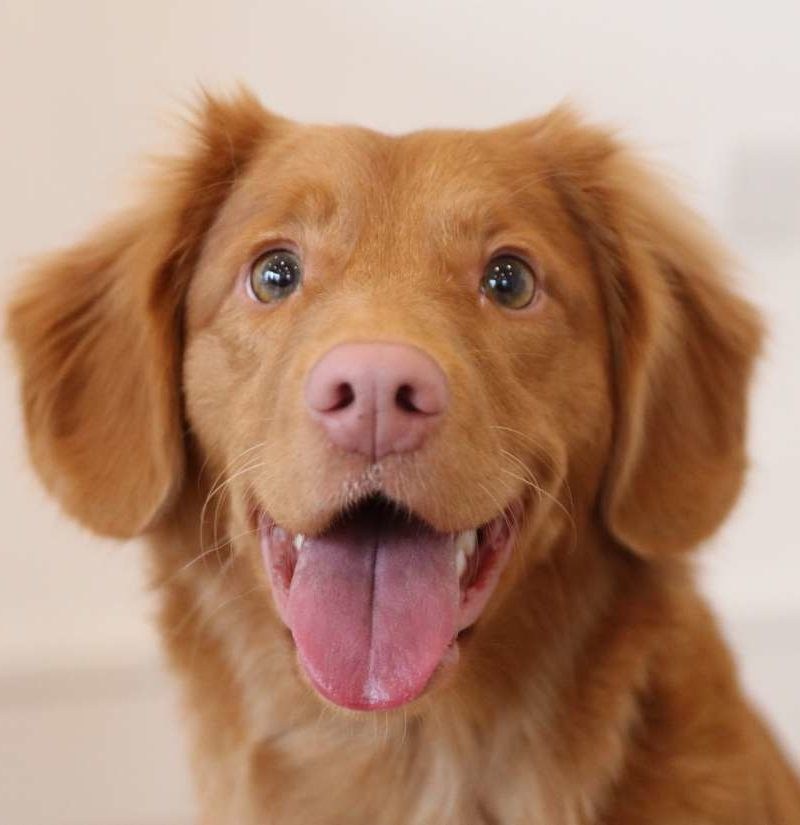

In [43]:
img

In [44]:
# - initialize the data_transform object that we'll use to pre-process the image
pre_processor = data_transform(train = False)

# - initialize a softmax function that we'll use for generating Prob. predictions
softmax = torch.nn.Softmax(dim = 0)

In [45]:
# ... preprocess/normalize the image
img_transformed = Variable(pre_processor(img).unsqueeze(0))
# ... model predictions
model_out = model(img_transformed.cuda()).cpu()

In [46]:
# ... from logits to predicted Pr.
pred_probs = softmax(model_out[0])

In [47]:
# ... pull the maximum predicted pr and class
max_pr, max_class = torch.max(pred_probs, dim = 0)
print('Max Class: {} | Max Pr: {}'.format(max_class, max_pr))

Max Class: 215 | Max Pr: 0.4031156897544861


In [48]:
# - what is the class #215? How can we find out? A list of the 1,000 ImageNet
#   class number and label can be found e.g. here:
#   https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

# - I already saved a copy of this file in our data directory. Let's load it
#   and look up the class label for 215
labels = json.load(open('{}imagenet_class_index.json'.format(data_path, 'rb')))

In [49]:
labels['215']

['n02101388', 'Brittany_spaniel']

In [50]:
# - feel free to take a look at the 1,000 classes of the ImageNet dataset. Most
#   of these pre-trained models are trained on this data -- and so predict the
#   same 1,000 classes
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

## Fine-tuning a pre-trained model

A pre-trained model may do poorly in classifying images into some classes of
interest to us. If that's the case, we can try to leverage the many things the
model has already learned by being trained on millions on images, but then adapt
it to our particular classification task. To do so, we'll need to:

- (a) adapt the model architecture, by replacing the final fully connected layer
  for a layer that fits our classification task (so predicting e.g. 2 rather
  1,000 classes)
- (b) train the pre-trained model for a few more iterations

We'll now practice how to do this by fine-tuning a pre-trained model to predict
a binary outcome: whether an image is of a street **protest**. In order to do
so, we have already **collected** and **annotated** some data for our quantity
of interest (so we have some images we know are of street protests and some
images we know are not).

### Data structure

Here a look at how your data needs to be set up to fit the requirements of the
`ImageFolder` and `DataLoader` utilities in pytorch.

- `root-data-folder`
  - `train`
    - `class-label`
      - `img`
      - `img`
      - ...
    - `class-label`
      - `img`
      - `img`
      - ...
    - ...
  - `test`
    - ...
      - ...
  - `val`
    - ...
      - ...

Here for example how it's set up for the data we'll now use to fine-tune the
model to predict images of street protests.

- `protest`
  - `train`
    - `negative`
      - `img`
      - `img`
      - ...
    - `positive`
      - `img`
      - `img`
      - ...
  - `test`
    - `negative`
      - `img`
      - `img`
      - ...
    - `positive`
      - `img`
      - `img`
      - ...


In [51]:
# - load a pre-trained model: e.g. Resnet50
model = models.resnet50(pretrained=True)

In [52]:
# - specifying HYPERPARAMETERS (researcher's choice! Some rules of thumb, but
#   usually you should perform a grid search --try many setups-- to see which
#   particular hyperparameter configuration works best)

# - specify the new number of outcome classes: 2 (binary: protest | not-protest)
num_classes = 2

# - how often do you want the loop to print information about model performance
report_num = 1 # ... every iteration

# - hyperparameters
set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
iter_num = 10 # Enter the desired number of iterations
set_batch_size = 4 # Enter the desired batch size

In [53]:
# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet50, last step is 2048 -> 2

In [54]:
# - specify some additional hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(),
                         lr=set_learn_rate,
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=set_step_size,
                                       gamma=set_gamma) # how to update learning rate

In [55]:
# - initialize preprocessing object
preprocess = data_transform()

In [56]:
# - specify the path to data for this particular classifier
model_path = '{}protest/'.format(data_path)

# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x]) for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=set_batch_size,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - making sure again that we're using GPU. Also, taking the opportunity to check
#   the model architecture and making sure that the "prediction head" has been
#   replaced and is now set up to predict a binary outcome.
use_gpu = True # /!\ Set to False if you run it in a machine with no GPUs
if use_gpu:
  model.cuda()

#### Model Training/Fine-tuning


In [57]:
# Initialize variables
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
since = time.time()
best_model_wts = model.state_dict()  # Warning: May lead to overfitting
best_acc = best_precision = best_recall = 0.0
loss_progress, acc_progress = [], []

# Training loop
for iteration in range(iter_num):
    if iteration % report_num == 0:
        print(f'Iteration {iteration + 1}/{iter_num}')
        print('-' * 10)

    for phase in ['train', 'test']:
        model.train(phase == 'train')  # Set training/evaluation mode
        running_loss, running_corrects, running_preds, running_labels = 0.0, 0, [], []

        for data in dataloaders[phase]:
            inputs, labels = data
            inputs, labels = (Variable(inputs.cuda()), Variable(labels.cuda())) if use_gpu else (Variable(inputs), Variable(labels))
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.data
            running_corrects += torch.sum(preds == labels.data)
            running_preds.extend(preds.tolist())
            running_labels.extend(labels.tolist())

        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]

        # Calculate precision and recall
        true_positives = sum(1 for p, l in zip(running_preds, running_labels) if p == l == 1)
        iter_precision = true_positives / sum(running_preds) if sum(running_preds) > 0 else 0
        iter_recall = true_positives / sum(running_labels) if sum(running_labels) > 0 else 0

        if iteration % report_num == 0:
            print(f'{phase} Loss: {iter_loss:.4f} Acc: {iter_acc:.4f} Precision: {iter_precision:.4f} Recall: {iter_recall:.4f}\n')

        if phase == 'test' and iter_acc > best_acc:
            best_acc, best_precision, best_recall, best_model_wts = iter_acc, iter_precision, iter_recall, model.state_dict()

        if phase == 'test':
            loss_progress.append(iter_loss.cpu())
            acc_progress.append(iter_acc.cpu())

    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... Reached good model accuracy, moving to the next model.')
        break

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:.4f}\n\n')


Iteration 1/10
----------
train Loss: 0.1644 Acc: 0.6412 Precision: 0.6111 Recall: 0.7765

test Loss: 0.1424 Acc: 0.8000 Precision: 0.9091 Recall: 0.6667

Iteration 2/10
----------
train Loss: 0.1315 Acc: 0.8059 Precision: 0.7826 Recall: 0.8471

test Loss: 0.1104 Acc: 0.8667 Precision: 0.8667 Recall: 0.8667

Iteration 3/10
----------
train Loss: 0.1012 Acc: 0.8824 Precision: 0.8824 Recall: 0.8824

test Loss: 0.0859 Acc: 0.8667 Precision: 0.8667 Recall: 0.8667

Iteration 4/10
----------
train Loss: 0.0847 Acc: 0.9000 Precision: 0.8864 Recall: 0.9176

test Loss: 0.0737 Acc: 0.9000 Precision: 0.9286 Recall: 0.8667

Iteration 5/10
----------
train Loss: 0.0892 Acc: 0.8588 Precision: 0.8861 Recall: 0.8235

test Loss: 0.0675 Acc: 0.9333 Precision: 1.0000 Recall: 0.8667

Iteration 6/10
----------
train Loss: 0.0764 Acc: 0.8941 Precision: 0.8602 Recall: 0.9412

test Loss: 0.0660 Acc: 0.9333 Precision: 1.0000 Recall: 0.8667

Iteration 7/10
----------
train Loss: 0.0671 Acc: 0.9294 Precision: 0.

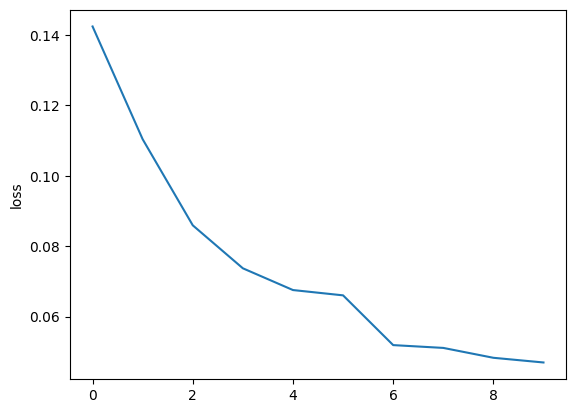

In [58]:
# - take a look at the evolution of the model loss
plt.plot(loss_progress)
plt.ylabel('loss')
plt.show()
plt.show()

In [59]:
# - here a function we created to more easily visualize the predictions this
#   fine-tuned model can make
def imshow(inp, title=None):
    """
    Description: This function takes a grid of images and shows them, making
        image visualization easy.
    Parameters:
        `inp`:      type <torch.FloatTensor> object.
        `title`:    type <list> of strings indicating the labels of the `inp`
                        images.
    Output:
        shows the images and their labels (if provided)
    """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, class_names, num_images, dataloaders, use_gpu):
    """
    Description: This function shows N (<num_images>) model predictions (top
        label + top probability).

    Parameters:
        `model`: type <torchvision.models.-modeltype->, the trained model.
        `num_images`: type <int> indicating the number of random images to show.
        `dataloaders`: type <dict> of a 'train' and a 'test
            torch.utils.data.dataloader.DataLoader.
        `use_gpu`: type <bol> indicating whether CUDA is available.

    Output:
        Prints out N predictions
    """
    images_so_far = 0

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

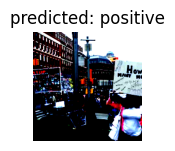

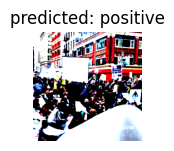

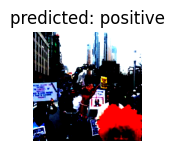

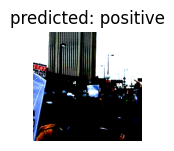

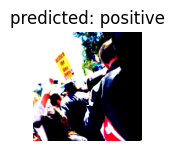

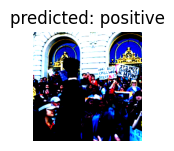

In [60]:
# - let's use it to check how the model classify some of the images in the test
#   set.
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

In [61]:
# - first create a 'models' directory
#   we'll save the fine-tuned model
output_path = '/content/models/'
os.mkdir(output_path)

In [62]:
# - PyTorch comes with a function to easily save models
model_filepath = '{}protest-model.pth'.format(output_path)
torch.save(model, model_filepath)

In [63]:
# - here is how you can reload the model again
model_new = torch.load(model_filepath)

In [64]:
# - using the model for generating predictions

# - load some example images to test how to use, on a "new" set of images, a model
#   you previously trained
pos_path = '{}protest/test/positive/'.format(data_path)
neg_path = '{}protest/test/negative/'.format(data_path)
pos_list = ['{}{}'.format(pos_path, x) for x in os.listdir(pos_path)[:5]]
neg_list = ['{}{}'.format(neg_path, x) for x in os.listdir(neg_path)[:5]]
test_img_path_list = pos_list + neg_list
new_dataset = []
for img_file in test_img_path_list:
    img = Image.open(img_file).convert('RGB')
    new_dataset.append(img)

In [65]:
len(new_dataset)

10

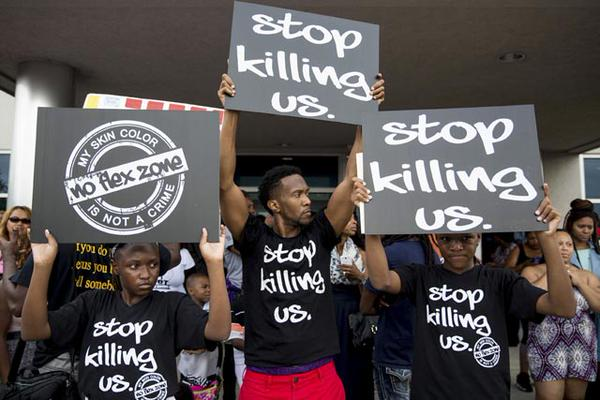

In [66]:
new_dataset[0]

In [67]:
# - specifying the transformation-preprocessing to apply to the images
preprocess = data_transform(train = False)

# - checking if the machine has GPUs and enabling GPU computing if so
use_gpu = torch.cuda.is_available()

In [68]:
# - use the model to perform predictions on this "new" set of images
# ... initialize output dataset and a counter
sigmoid = nn.Sigmoid() # Sigmoid rather than Softmax activation: binary outcome
output_data = pd.DataFrame()
counter = 0
total = len(new_dataset)
# ... iterate through the new images to predict
for z in range(0, len(new_dataset)):
    counter += 1
    print('image: {}/{}'.format(counter, total))
    img_filename = test_img_path_list[z]
    img = new_dataset[z]
    # ... initialize output dict object for this iteration/img
    new_entry = {}
    # ... transform-preprocess this imags
    var = Variable(preprocess(img).unsqueeze(0))
    # ... make the model prediction
    pred = model_new(var.cuda())
    # ... pull the predicted class probabilities and create a dataframe with them
    probs, indeces = sigmoid(pred).cpu().data.sort()
    probs = [round(x, 3) for x in list(probs.numpy()[0])]
    indeces = list(indeces[0][:2])
    labels = [['negative', 'positive'][i] for i in indeces]
    pred_df = pd.DataFrame({'label':labels,
                            'probs':probs})
    pred_df_t = pred_df.transpose()
    final_pred_df = pd.DataFrame(pred_df_t.iloc[1]).transpose()
    final_pred_df.columns = labels
    # ... adding some extra information about the image and prediction
    final_pred_df['img'] = '/'.join(img_filename.split('/')[-2:])
    final_pred_df['max_class'] = ['negative', 'positive'][indeces[1]]
    final_pred_df['max_pr'] = max(probs)
    output_data = pd.concat([output_data, final_pred_df])
output_data = output_data.reset_index(drop=True)

image: 1/10
image: 2/10
image: 3/10
image: 4/10
image: 5/10
image: 6/10
image: 7/10
image: 8/10
image: 9/10
image: 10/10


In [69]:
output_data


,positive,negative,img,max_class,max_pr
0,0.314,0.436,positive/9920.jpg,negative,0.436
1,0.533,0.174,positive/44938.jpg,positive,0.533
2,0.775,0.091,positive/42386.jpg,positive,0.775
3,0.957,0.02,positive/51085.jpg,positive,0.957
4,0.579,0.19,positive/45021.jpg,positive,0.579
5,0.149,0.831,negative/45130.jpg,negative,0.831
6,0.185,0.629,negative/7.jpg,negative,0.629
7,0.348,0.436,negative/8590.jpg,negative,0.436
8,0.082,0.907,negative/7896.jpg,negative,0.907
9,0.09,0.789,negative/3019.jpg,negative,0.789
